In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
audit_data <- read_csv("trial.csv") |>
    mutate(Risk = as_factor(Risk))
audit_data

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,6,2.50,2,6.68,5.0,2,3.380,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5.0,2,0.940,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5.0,2,0.000,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6.0,6,11.750,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5.0,2,0.000,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,0.83,2,0.83,5.0,2,2.950,2,2,0,2,0,2,2.0,0
3.89,7,1.10,4,7.41,4,8.51,5.0,2,44.950,6,2,0,2,0,2,3.2,1
3.89,8,8.50,6,12.03,6,20.53,5.5,4,7.790,4,2,0,2,0,2,4.2,1
3.89,8,8.40,6,11.05,6,19.45,5.5,4,7.340,4,2,0,2,0,2,4.2,1


In [3]:
audit_prop <- audit_data |>
    group_by(Risk) |>
    summarize(count = n())
audit_prop

audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_train <- training(audit_split)
audit_test <- testing(audit_split)


Risk,count
<fct>,<int>
0,290
1,486


In [4]:
mean_train <- audit_train |>
    group_by(Risk) |>
    summarize(mean_para_a = mean(PARA_A),
              mean_para_b = mean(PARA_B),
              mean_money_value = mean(Money_Value, na.rm = TRUE),
              mean_sector_score = mean(Sector_score),
              mean_loss_score = mean(LOSS_SCORE),
              mean_history_score = mean(History_score),
              mean_district_score = mean(District))
mean_train

# might get rid of the sector score/other control
# risk factors for this proposal table in particular,
# inherit risk factors seem to be more of interest (?)

# Could make a bar chart to compare values between fraud/non fraud businesses
# for inherit risk factors/things that actually make sense as means

Risk,mean_para_a,mean_para_b,mean_money_value,mean_sector_score,mean_loss_score,mean_history_score,mean_district_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2854839,0.2510009,0.2965463,32.93618,2.00000,2.000000,2.000000
1,3.8253588,15.4788462,19.4755495,13.36783,2.10989,2.258242,2.824176


In [5]:
colnames(audit_data)

[1] "Sector_score"  "LOCATION_ID"   "PARA_A"        "SCORE_A"      
 [5] "PARA_B"        "SCORE_B"       "TOTAL"         "numbers"      
 [9] "Marks"         "Money_Value"   "MONEY_Marks"   "District"     
[13] "Loss"          "LOSS_SCORE"    "History"       "History_score"
[17] "Score"         "Risk"

Columns:

-sector_score (past risk score of target unit)
-LOCATION_ID (city/province)
-PARA_A (discrepancies in planned-expenditure)
-SCORE_A (???)
-PARA_B (discrepancies in unplanned-expenditure)
-SCORE_B (???)
-TOTAL (discrepancies in non-para reports)
-numbers (historical discrepancy score)
-Marks (???)
-Money_Value (misstatements)
-MONEY_Marks (???)
-District (???)
-Loss (past year)
-LOSS_SCORE (???)
-History (average loss in past 10 years)
-History_score (???)
-Score (???)
-Risk (1 = suspicious, 0 = normal) (i think???)


Auditing is the practice of detecting fraud (unfair/illegal practices within firms).
Audit paras are the summary reports of external auditing.
Data collected by Comptroller and Auditor General (CAG) of India for 777 firms between 2015-2016.

Goal of classification is to detect high-risk firms that need significant investigation.
Question: Can we predict whether a firm is a risk or not based on ______?

In [6]:
# What kind of plot to make?? (What predictors are we using?)

In [7]:
# Steps for this plot:

# -isolate chosen variables in training set
# -scale and center variables
# -create 2 boxplots, one for fraud and non fraud businesses each, x will be a variable and the y's will be the scale its centered around(??)

# maybe create a grid of boxplots with each cell having its x be a variable and y being its unit, 
# separated into two larger sections divided by fraud/not fraud

# maybe create a grid of histograms of each variable, coloured differently depending on if business is fraudulent (+ separated into 2 columns for easy comparison)
# default count of occurences for the "score" variables (like loss score), use values for numeric variables (like para a)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



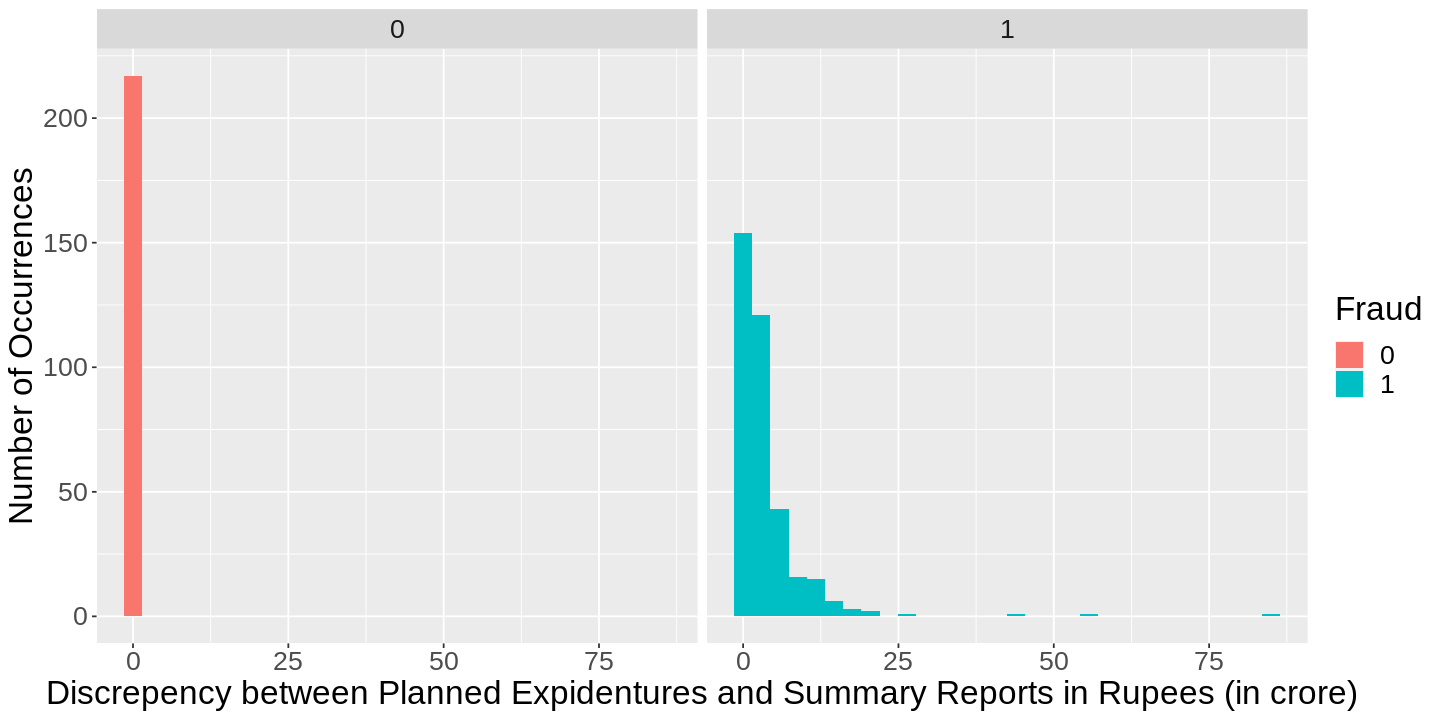

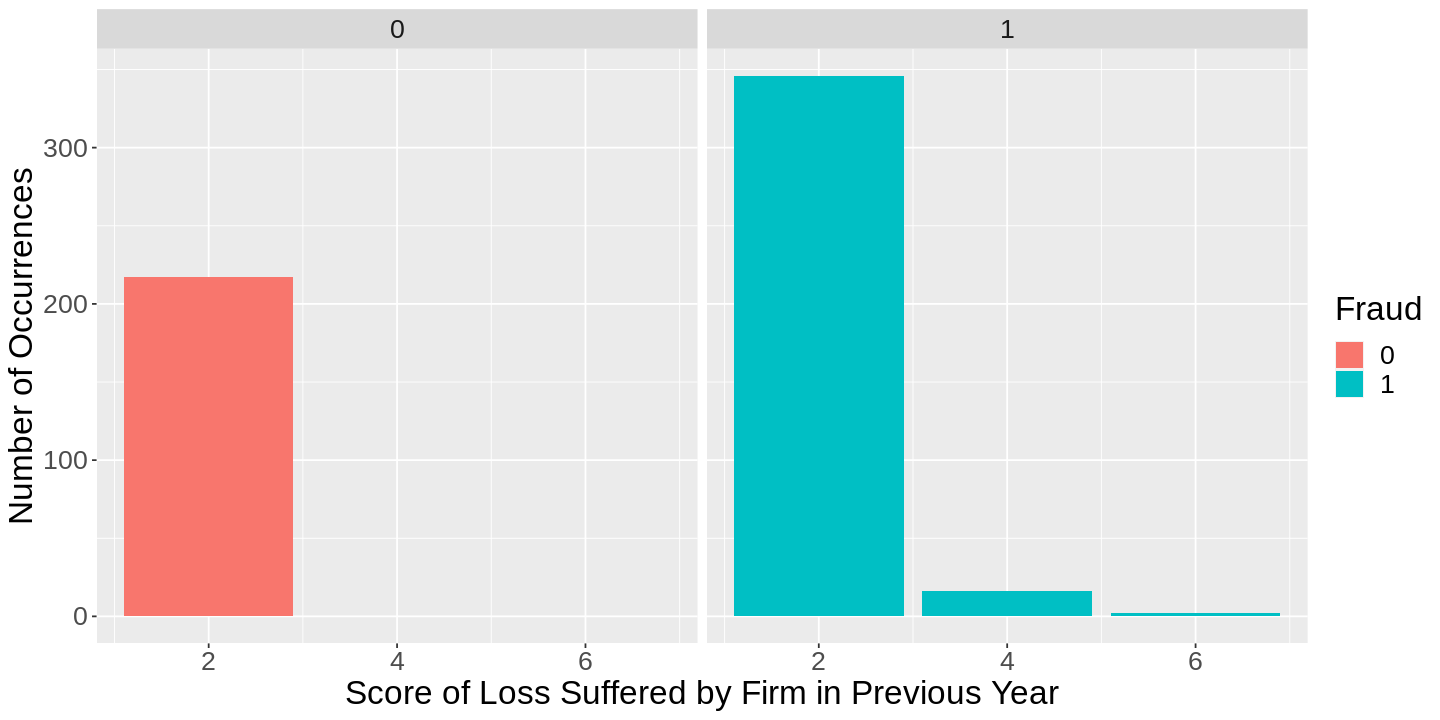

In [44]:
# unscaled_audit_train <- audit_train |>
#     select(c(Risk, PARA_A, PARA_B, Money_Value, Sector_score, LOSS_SCORE, History_score, District))

# uat_recipe <- recipe(Risk ~ ., data = unscaled_audit_train) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors()) |>
#     prep()

# scaled_audit_train <- bake(uat_recipe, unscaled_audit_train)
# scaled_audit_train

# sat_plot <- ggplot(scaled_audit_train, aes(x = PARA_A)) +
#     geom_bar() +
#     facet_grid(rows = vars(Risk))
# sat_plot

options(repr.plot.width = 12, repr.plot.height = 6)

select_audit_train <- audit_train |>
    select(c(Risk, PARA_A, PARA_B, Money_Value, Sector_score, LOSS_SCORE, History_score, District))

# Histogram template for numeric variables
para_A <- ggplot(select_audit_train, aes(x = PARA_A, fill = Risk)) +
    geom_histogram() +
    xlab("Discrepency between Planned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Occurrences") +
    labs(fill = "Fraud") +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))
para_A

# Barplot template for score variables
loss <- ggplot(select_audit_train, aes(x = LOSS_SCORE, fill = Risk)) +
    geom_bar() +
    xlab("Score of Loss Suffered by Firm in Previous Year") +
    ylab("Number of Occurrences") +
    labs(fill = "Fraud") +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))
loss

# Figure out how to rename 0 and 1